<a href="https://colab.research.google.com/github/rekalantar/LiverSegmentation/blob/master/LiverSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

Liver segmentation is an important step in many medical imaging applications, such as liver cancer diagnosis and treatment planning. In this tutorial, we will be walking through the steps of liver segmentation using a U-Net architecture. Segmentation can be a challenging task, especially when it comes to medical images. The images can be of varying quality, and the structures of interest can appear differently in different patients. However, with the recent advances in deep learning, it has become possible to achieve high accuracy in several segmentation tasks. By the end of this tutorial, you should have a good understanding of the key concepts and techniques used in 3D medical image handling and be able to apply them to your own projects.


Let's start by checking the GPU specifications provided by Google Colab.

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 
     

  Preparing metadata (setup.py) ... done
Gen RAM Free: 12.8 GB  | Proc size: 92.9 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


**Dataset**

For our model, we will be using a dataset publicly available from the IRCAD research center in France. This dataset includes 20 annotated 3D CT series, out of which 15 will be used for training and validation while the remaining 5 will be used for testing.
You can easily access this dataset by either downloading it directly from the link : https://www.dropbox.com/s/8h2avwtk8cfzl49/ircad-dataset.zip?dl=0
or you can also access it by cloning it from my Github repository

In [2]:
# !wget https://www.dropbox.com/s/8h2avwtk8cfzl49/ircad-dataset.zip?dl=0
# !unzip '/content/ircad-dataset.zip?dl=0'

!git clone https://github.com/rekalantar/LiverSegmentation
data_path = '/content/LiverSegmentation/dataset'

Cloning into 'LiverSegmentation'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 85 (delta 5), reused 17 (delta 3), pack-reused 65
Unpacking objects: 100% (85/85), done.
Checking out files: 100% (49/49), done.


**Import Libraries**

In [4]:
import os
import io
import random
import nibabel
import numpy as np
from glob import glob
import nibabel as nib
import tensorflow as tf
from nibabel import load
import matplotlib.pyplot as plt
from keras.utils import Sequence
from IPython.display import Image, display
from skimage.exposure import rescale_intensity
from skimage.segmentation import mark_boundaries
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

**Define DataGenerators**

We create a custom data generator class, called NiiDataGenerator, that inherits from the built-in tf.keras.utils.Sequence class. This allows for easy loading of data for training and testing of a deep learning model in batches. The class takes four arguments in the constructor: image_filenames, mask_filenames, batch_size, and image_size. These are the paths to the image files, corresponding mask files, the batch size, and the desired image size, respectively. The class then implements the two required methods of the Sequence class: __len__() and __getitem__().

__len__() returns the number of batches in the data generator, which is calculated as the number of images divided by the batch size, rounded up to the nearest whole number.

__getitem__(idx) loads and returns one batch of data, where idx is the index of the batch to be loaded. It loads the image and mask files of the current batch using nibabel library, get the data from the image object, randomly select one slice from the volume, resize the image and mask to the desired image size, and returns the image and mask data as a tuple in format of (x,y)

It's worth noting that, this generator loads the data from nifti file format and each image volume is composed of a stack of 2D slices, this generator loads randomly one slice from the stack in each iteration.

In [36]:
class NiiDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, mask_filenames, batch_size, image_size):
        self.image_filenames = image_filenames
        self.mask_filenames = mask_filenames
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        x = np.zeros((self.batch_size, *self.image_size, 1))
        y = np.zeros((self.batch_size, *self.image_size, 1))

        for i, (image_filename, mask_filename) in enumerate(zip(batch_x, batch_y)):
            image = nib.load(image_filename)
            mask = nib.load(mask_filename)
            # get the data from the image object
            image_data = image.get_fdata()
            mask_data = mask.get_fdata()
            # get random slice from the volumes
            slice_index = random.randint(0, image_data.shape[2] - 1)
            x[i, :, :, 0] = image_data[:, :, slice_index]
            y[i, :, :, 0] = mask_data[:, :, slice_index]
        
        return x, y

In [37]:
train_images = sorted(glob(os.path.join(data_path, 'train', '*_orig.nii.gz')))
train_masks = sorted(glob(os.path.join(data_path, 'train', '*_liver.nii.gz')))

batch_size = 1 # The batch size to use when training the model
image_size = (512, 512)  # The size of the images

train_generator = NiiDataGenerator(train_images[:10], train_masks[:10], batch_size, image_size)
val_generator = NiiDataGenerator(train_images[10:], train_masks[10:], batch_size, image_size)

**Defiine UNet Model**

In this tutorial, we will be implementing a UNet model, a popular deep learning architecture used in semantic segmentation tasks like liver segmentation.

First, we define two helper functions: encoder and decoder. The encoder function is used to create the encoding part of the UNet model and takes in inputs, number of filters and the pool size. It consists of a 2D convolutional layer with kernel size of (3,3), relu activation and same padding, then a max pooling layer with the provided pool size.

The decoder function is used to create the decoding part of the UNet model, it takes inputs, concatenation input, number of filters and transpose size. It starts by concatenating the input of the decoder with the output of the corresponding encoder layer, it then applies a transposed convolutional layer with kernel size of transpose_size, a stride of (2,2) and a padding of 'same', followed by a 2D convolutional layer with the same parameters as the encoder function.

Next, we define the main function UNet, this function starts with creating an input layer with the provided img_size which is the desired input shape of the images, it is set to (512,512,1) by default.

The function then goes through four encoder blocks by calling the encoder function and passing the outputs of previous blocks as inputs, in each block filters and pool_size are incremented. A bottleneck is created by applying a convolutional layer with 512 filters and a kernel size of (3,3) and a relu activation.

After that, the function uses the bottleneck output and goes through four decoder blocks by calling the decoder function, in each block filters are decremented. Each decoder block takes the output of the previous block as input and concatenates it with the output of the corresponding encoder block.

Finally, the function applies a final convolutional layer with 1 filter, a kernel size of (1,1) and a sigmoid activation function, to produce the output of the model.

The last step is to create a Keras model object by specifying the inputs and outputs and return it. This creates an instance of the UNet model, which can then be trained, evaluated, and used for predictions.

In [38]:
def encoder(inputs, filters, pool_size):
    conv_pool = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    conv_pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(conv_pool)
    return conv_pool

def decoder(inputs, concat_input, filters, transpose_size):
    up = tf.keras.layers.Concatenate()([tf.keras.layers.Conv2DTranspose(filters, transpose_size, strides=(2, 2), padding='same')(inputs), concat_input])
    up = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(up)
    return up

def UNet(img_size=(512,512,1)):
    inputs = tf.keras.Input(img_size)
    print(inputs.shape)
    print()

    # Encoder
    conv_pool1 = encoder(inputs, 32, (2, 2))
    print("\t Enc. 1 ->", conv_pool1.shape)
    print()
    conv_pool2 = encoder(conv_pool1, 64, (2, 2))
    print("\t\t Enc. 2 ->", conv_pool2.shape)
    print()
    conv_pool3 = encoder(conv_pool2, 128, (2, 2))
    print("\t\t\t Enc. 3 ->", conv_pool3.shape)
    print()
    conv_pool4 = encoder(conv_pool3, 256, (2, 2))
    print("\t\t\t\t Enc. 4 ->", conv_pool4.shape)
    print()

    # Bottleneck
    bridge = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv_pool4)
    print("\t\t\t\t\t Bridge Conv ->", bridge.shape)
    print()

    #Decoder
    up6 = decoder(bridge, conv_pool3, 256, (2, 2))
    print("\t\t\t\t Dec. 4 ->", up6.shape)
    print()
    up7 = decoder(up6, conv_pool2, 128, (2, 2))
    print("\t\t\t Dec. 3 ->", up7.shape)
    print()
    up8 = decoder(up7, conv_pool1, 64, (2, 2))
    print("\t\t Dec. 2 ->", up8.shape)
    print()
    up9 = decoder(up8, inputs, 32, (2, 2))
    print("\t Dec. 1 ->", up9.shape)
    print()
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(up9)
    print(outputs.shape)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

model = UNet()

(None, 512, 512, 1)

	 Enc. 1 -> (None, 256, 256, 32)

		 Enc. 2 -> (None, 128, 128, 64)

			 Enc. 3 -> (None, 64, 64, 128)

				 Enc. 4 -> (None, 32, 32, 256)

					 Bridge Conv -> (None, 32, 32, 512)

				 Dec. 4 -> (None, 64, 64, 256)

			 Dec. 3 -> (None, 128, 128, 128)

		 Dec. 2 -> (None, 256, 256, 64)

	 Dec. 1 -> (None, 512, 512, 32)

(None, 512, 512, 1)


In this tutorial, we will be discussing the dice coefficient and its usage as a metric to evaluate the performance of semantic segmentation models like UNet.

The dice coefficient, also known as Sørensen-Dice coefficient, is a commonly used metric to evaluate the performance of semantic segmentation models. It is defined as the ratio of the intersection of the predicted segmentation and the true segmentation to the union of them.

To calculate the dice coefficient, we will create a function called dice_coef which takes in two arguments: y_true and y_pred which are the true segmentation and the predicted segmentation, respectively.

The function starts by flattening the y_true and y_pred input into 1-D arrays, it is done using the tf.keras.backend.flatten function. Then, we calculate the intersection of the true and predicted segmentation by taking the element-wise product of the flattened true and predicted segmentation and then summing the resulting array.

Finally, we calculate the dice coefficient by dividing twice the intersection by the sum of the flattened true and predicted segmentation plus a smoothing term. This is done by adding a small value to the numerator and denominator to prevent division by zero errors.

The result of the dice coefficient calculation is a scalar value between 0 and 1, where a value closer to 1 indicates a better segmentation performance. By using dice coefficient as a metric we can have a good evaluation of the model performance.

In [39]:
def dice_coef(y_true, y_pred, smooth=1.):
  """
  Dice = (2*|X & Y|)/ (|X|+ |Y|)
        =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
  ref: https://arxiv.org/pdf/1606.04797v1.pdf
  """
  y_true_f = tf.keras.backend.flatten(y_true)
  y_pred_f = tf.keras.backend.flatten(y_pred)
  intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


With our UNet model defined and the dice coefficient metric implemented, we are now ready to train the model. We can begin by compiling the model by specifying the loss function and optimizer. In this case, we will be using the binary cross entropy loss as it is commonly used for binary classification tasks.

Next, we will train the model using our training data. During training, we will monitor the performance of the model on the validation data using the dice similarity coefficient as a metric. This will give us an insight on how the model is performing on unseen data.

Finally, we will train the model for 100 epochs and save the best model based on performance on the validation data. This will ensure that we are using the best performing model for predictions and further analysis.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='bce', metrics=[dice_coef])

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=200,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              callbacks=[checkpoint])

**Evaluate Model**

Once the training process is completed, it is important to evaluate the performance of our model. One way to do this is by visualizing the training and validation losses, as well as the Dice scores. This will give us a clear understanding of how the model has performed during training.

We may notice that, while the training loss decreases and the Dice score increases, the validation loss and Dice score may not improve consistently. In some cases, more training may be needed to achieve the best performance.

It's important to note that in this demonstration, the model is only trained for 100 epochs to make the training process more efficient and faster. In practice, more epochs may be necessary to achieve the best validation performance.

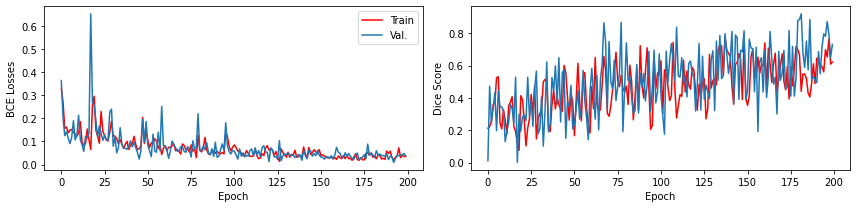

In [131]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'])
plt.ylabel('BCE Losses')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val.'], loc='upper right')
plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'], color='r')
plt.plot(history.history['val_dice_coef'])
plt.ylabel('Dice Score')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

Before making predictions on new images, we first need to load the best-trained weights from our model. These weights were obtained during the training process and will ensure that our model can make accurate predictions on new images.

In [146]:
model.load_weights('/content/best_model.h5')

This code is loading test images and test masks using the glob function, which is used to search for all the pathnames matching a specified pattern. It sorts the images and masks and create a test generator object with the information of all test images and test masks with a batch size and the size of the images. Then it uses this generator object to get the next image and mask pairs. It uses the trained model to predict the output on the test images and assigns the result to test_pred. Finally, the code converts the predicted output(test_pred) into binary format by thresholding it. Any value greater or equal to 0.5 will be converted to 1 and less than 0.5 will be converted to 0.

In [151]:
test_images = sorted(glob(os.path.join(data_path, 'test', '*_orig.nii.gz')))
test_masks = sorted(glob(os.path.join(data_path, 'test', '*_liver.nii.gz')))

test_generator = NiiDataGenerator(test_images, test_masks, batch_size, image_size)

test_img, test_mask = next(iter(test_generator))

test_pred = model.predict(test_img)
test_pred_thresh = (test_pred[0,...,0] >= 0.5).astype(np.uint8)

1/1 [==============================] - 0s 18ms/step


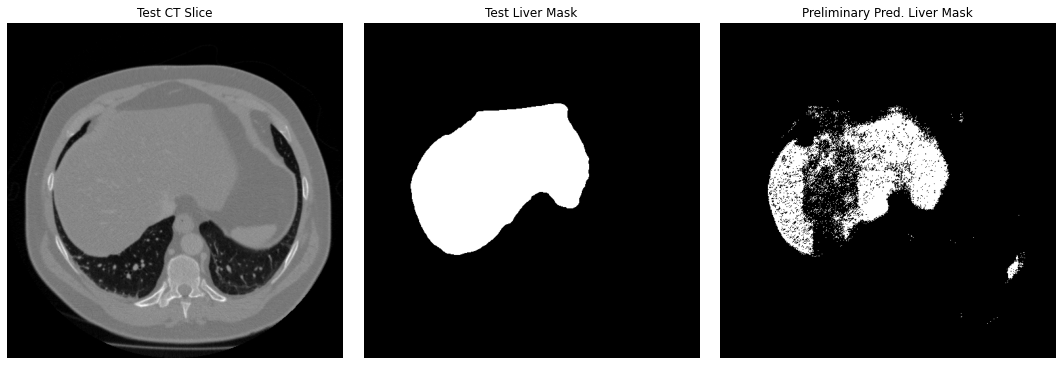

In [152]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Test CT Slice')
plt.imshow(np.rot90(test_img[0,...,0], 1), cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Test Liver Mask')
plt.imshow(np.rot90(test_mask[0,...,0], 1), cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.title('Preliminary Pred. Liver Mask')
plt.imshow(np.rot90(test_pred_thresh, 1), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

We have successfully developed an algorithm for liver segmentation on CT scans. While it is not yet fully optimized, this tutorial serves as a guide to creating an end-to-end medical image segmentation task. There are several potential areas for improvement that can be considered to increase the performance of the algorithm.

One way to improve performance is to increase the size of the training dataset by using more images. Additionally, using data augmentation techniques such as flipping, rotation, and elastic deformation can also help to improve performance. Another approach is to incorporate pre-training on a related task, such as training on a larger dataset of natural images before fine-tuning on medical images.

Advanced optimization techniques such as transfer learning, fine-tuning, or a combination of different models can also be considered. Tuning the network's hyperparameters such as batch size, number of filters, kernel size, and learning rate, can also help to improve performance. Using ensemble methods like bagging, boosting, and stacking for predictions can also lead to better results. Testing other architectures such as DenseNet, InceptionNet, or ResNeXt can also be beneficial.

Regularizing the model with techniques such as Dropout and L2 weight decay can help to prevent overfitting and improve performance. Moreover, it would be beneficial to include a more robust evaluation metric such as Jaccard similarity coefficient or mean intersection-over-union to assess model performance instead of relying solely on accuracy.